### Clustering

---


### A. Import Python Modules and Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for and t-SNE
from sklearn.manifold import TSNE,MDS
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import cluster #needed for k-Means clustering
from sklearn import metrics #needed for Silhouette method
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

#### Load the dataset

In [ ]:
df = pd.read_csv("./tracks.csv")
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1495,23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,opera
1496,22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,opera
1497,23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,opera
1498,23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,opera
1499,23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,opera


In [ ]:
df.isna().sum()

,0
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0
key,0
loudness,0
mode,0
speechiness,0
acousticness,0


# Parameter tuning

Genre is dropped, as it is categorical data.

Explicit is mapped to 0 and 1, to replace the bool, as well as to be more consistent with other features being in the range of 0-1

Popularity is changed to a boolean value of 0 and 1, with songs ranked over 50 being considered popular. This produced better results for clustering and a more definitive silhouette coefficient.

In [ ]:
df.drop(columns=["track_genre"], inplace=True, errors='ignore')

bool_mapper = {
    False: 0,
    True: 1,
}
df['popularity'] = df['popularity'].apply(lambda x: 1 if x > 50 else 0)
df['explicit'] = df['explicit'].replace(bool_mapper)
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1495,0,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4
1496,0,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4
1497,0,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1
1498,0,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4
1499,0,257800,0,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4


Here we created the `preprocess_pipeline` in order to make sure that the features of this dataset were appropriately scaled and transformed before being fed into the clustering model.

In [ ]:
y = df['popularity']
X = df.drop('popularity', axis=1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# outliers
# - duration
# - loudness
# - speechiness
# - instrumentalness
# - liveness
# - tempo


columns_outliers_no_skew = ["speechiness", "instrumentalness", "liveness"]

columns_outliers_skewed = ['duration_ms', 'loudness', 'tempo']

columns_no_outliers_skewed = ["duration_ms",
                              "danceability",
                              "energy",
                              "loudness",
                              "speechiness",
                              "acousticness",
                              "instrumentalness",
                              "liveness",
                              "valence",
                              "tempo",
                              ]

columns_no_outliers_no_skew = [col for col in X.columns if
                               col not in columns_outliers_no_skew and col not in columns_no_outliers_skewed and col not in columns_outliers_skewed]

outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("log_transform", preprocessing.PowerTransformer(method="yeo-johnson")),
        ("scaler", preprocessing.RobustScaler())
    ]
)

outliers_skewed_pipeline = Pipeline(steps=[
    ("log_transform", preprocessing.PowerTransformer(method="yeo-johnson")),
    ('scale', preprocessing.RobustScaler())
])

no_outliers_skewed_pipeline = Pipeline(
    steps=[
        ("log_transform", preprocessing.PowerTransformer(method="yeo-johnson")),
        ("scaler", preprocessing.MinMaxScaler())
    ]
)

no_outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("scaler", preprocessing.MinMaxScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("outliers_skewed", outliers_skewed_pipeline, columns_outliers_skewed),
        ("outliers_not_skewed", outliers_no_skew_pipeline, columns_outliers_no_skew),
        ("no_outliers_skewed", no_outliers_skewed_pipeline, columns_no_outliers_skewed),
        ("no_outliers_no_skew", no_outliers_no_skew_pipeline, columns_no_outliers_no_skew)
    ],
    remainder="passthrough"
)

- Firsly, for features with strong outliers and no skew, we applied a Yeo-Johnson transform followed by scaling with the RobustScaler.
- Then, for highly skewed features with significant outliers, we applied a Yeo-Johnson power transformation followed by robust scaling to mitigate the impact of extreme values.
- Then for moderately skewed features without strong outliers, we applied a Yeo-Johnson transform followed by MinMax scaling.
- And lastly, features without noticeable skew or outliers were scaled directly using a MinMax scaler.

**Note**: We chose the Yeo-Johnson transformation over a log transformation because it can handle both positive and negative values, including zeros, without requiring manual data shifts, providing a more flexible and robust normalization method. (reference [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html))


We're using Random Forest classifier, as it was tested with the best results in classification

In [ ]:
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (1500, 15)


---

### Scatterplot




In [ ]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):


    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

---
### K-Means Clustering (Roy)

Number of clusters $k$.

For determining the ideal value of K, the elbow-method was used, mapping the sum of squares of the clusters to the graph. When the decline starts to flatten, like a bent elbow, that is the ideal value of k.

Through this, k=3 was the ideal value of k

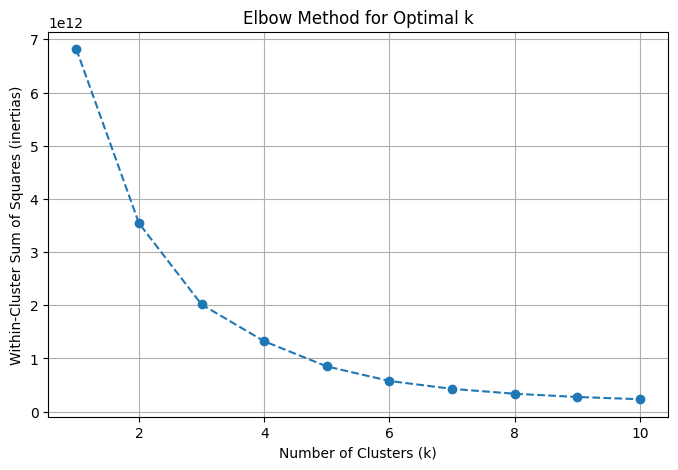

In [ ]:
inertias = [] # the sum of squared distances
k_values = range(1, 11)

for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (inertias)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [ ]:
k = 3

#### Run k-Means

This creates a pipeline that runs the preprocessing pipeline, and then kmeans

In [ ]:
kmeans_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])
clustered_model = kmeans_pipeline.fit(df)
preprocessed_data = clustered_model.transform(df)
preprocessed_data,clustered_model['kMeans'].cluster_centers_

(array([[2.07723908, 1.3820374 , 2.61049984],
        [2.07767857, 1.36979418, 2.42717346],
        [2.47423213, 2.87115995, 1.34349106],
        ...,
        [2.71963625, 1.26909059, 2.79727146],
        [2.73175686, 2.15057432, 3.06961166],
        [3.7224944 , 2.57320151, 2.17340216]]),
 array([[-0.31801615,  0.37317869,  0.19804008,  0.64670748,  0.04790905,
          0.19949926,  0.40175123,  0.62537095,  0.64445836,  0.3391516 ,
          0.59969916,  0.22882352,  0.02288489,  0.55148327,  0.63992993,
          0.60277641,  0.19785276,  0.48647518,  0.53680982,  0.79785276,
          0.        ],
        [ 0.41247392, -0.49869938, -0.30887625, -0.24872691,  0.10210926,
          0.14038472,  0.47779833,  0.33883528,  0.31150476,  0.22249969,
          0.23161416,  0.73316067,  0.04783844,  0.53107448,  0.35330949,
          0.48670382,  0.02240326,  0.45121274,  0.75967413,  0.75152749,
          0.        ],
        [-0.05643724, -0.33819244, -0.09832405,  0.09132576,  2.0532356

### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the dataset.

In [ ]:
preprocessed_data.shape
data_and_centers = np.r_[preprocessed_data,clustered_model['kMeans'].cluster_centers_.T]
data_and_centers.shape

(1521, 3)

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [ ]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")
XYcoordinates.shape

transformation complete


(1521, 2)

In [ ]:
clustering_scatterplot(points=XYcoordinates[:-k,:],
                       labels=clustered_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:],
                       title='Tracks clustered by T-SNE')

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1518 but size of corresponding boolean axis is 1500

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [ ]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [ ]:
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
1495,0,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,3
1496,0,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,3
1497,0,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,3
1498,0,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,3
1499,0,257800,0,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,3


#### Compute the mean value of each attribute for each cluster

In [ ]:
df.groupby('cluster').mean()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster,,,,,,,,,,,,,,,
0,0.000000,201258.824847,0.148676,0.632939,0.750532,4.680244,-5.696859,1.000000,0.094738,0.113558,0.199518,0.205758,0.445613,126.521436,3.967413
1,0.000000,206556.031429,0.165714,0.626766,0.711989,5.834286,-6.104851,0.000000,0.097500,0.156858,0.108718,0.195755,0.437807,119.129166,3.971429
2,1.000000,201642.031373,0.101961,0.620663,0.674706,4.992157,-5.984176,0.545098,0.067861,0.222890,0.119830,0.162611,0.453702,117.909627,3.929412
3,0.089109,227942.995050,0.000000,0.304934,0.252006,4.831683,-14.871869,0.868812,0.045222,0.877228,0.206267,0.201147,0.198265,102.729101,3.663366


- Cluster 0 are unpopular tracks all in major.
- Cluster 1 are quieter, acoustic, lower-tempo, lower-energy tracks.
- Cluster 2 tracks that rank from 50-100 in popularity.
- Cluster 3 are unpopular tracks all in minor.

# Clustering with DBScan

In [ ]:
data = df[['loudness', 'energy']].dropna().values

In [ ]:
# DBSCAN parameters
epsilon = 2
min_samples = 10

# Run DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(data)
labels = db.labels_

scaled_data = StandardScaler().fit_transform(data)

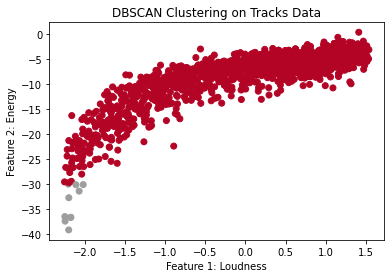

In [ ]:
# Map labels to colors
colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426' if x == 0 else '#9e9e9e', labels))

plt.scatter(scaled_data[:, 1], data[:, 0], c=colors, marker="o", picker=True)
plt.title('DBSCAN Clustering on Tracks Data')
plt.xlabel('Feature 1: Loudness')
plt.ylabel('Feature 2: Energy')
plt.show()

/Users/adamgreenan/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


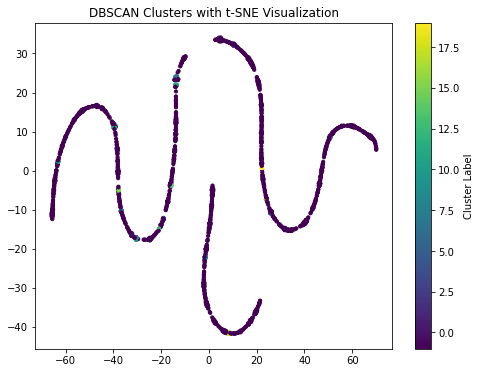

In [ ]:
X = df.select_dtypes(include=['int64', 'float64'])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Use t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title("DBSCAN Clusters with t-SNE Visualization")
plt.colorbar(label='Cluster Label')
plt.show()

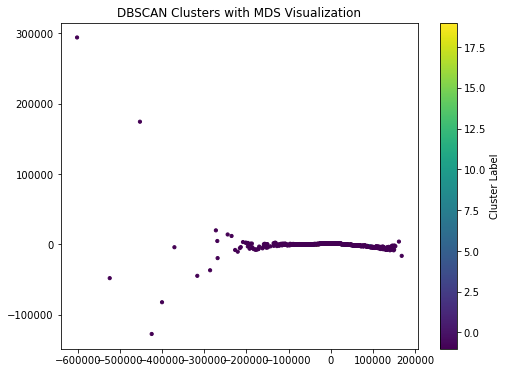

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=labels, cmap='viridis', s=10)
plt.title("DBSCAN Clusters with MDS Visualization")
plt.colorbar(label='Cluster Label')
plt.show()

# Conclusion

k-means clustering assumes that clusters are spherical and equally sized. It performed well in forming clear, compact clusters when the number of clusters (k) was appropriately chosen. However, it required setting k manually in advance, and its performance degraded if the true clusters were not globular or were very differently sized.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise), on the other hand, does not require specifying the number of clusters beforehand. It was able to discover clusters of arbitrary shape and effectively identified noise points (outliers). DBSCAN performed better when clusters were irregularly shaped but was sensitive to the choice of parameters like eps (neighborhood size) and min_samples (minimum points in a neighborhood).